In [3]:
import k3d
import numpy as np
import open3d as o3d
import nibabel as nib
import matplotlib.pyplot as plt
import skimage.transform as tr
from scipy.ndimage import zoom

In [2]:
pip install nibabel

     |████████████████████████████████| 3.3MB 410kB/s eta 0:00:01     |█████████████████▍              | 1.8MB 717kB/s eta 0:00:03
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
path = 'test_set2020/011.nii.gz'
img = nib.load(path)

## Metrics for evaluating

In [101]:
import numpy
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
import nrrd
from glob import glob



def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds




def hd(result, reference, voxelspacing=None, connectivity=1):
    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd


def hd95(result, reference, voxelspacing=None, connectivity=1):
    """
    95th percentile of the Hausdorff Distance.
    Computes the 95th percentile of the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. Compared to the Hausdorff Distance, this metric is slightly more stable to small outliers and is
    commonly used in Biomedical Segmentation challenges.
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of
        elements along each dimension, which is usually given in mm.
    See also
    --------
    :func:`hd`
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = numpy.percentile(numpy.hstack((hd1, hd2)), 95)
    return hd95


def dc(input1, input2):

    """
    Dice coefficient
    
    Computes the Dice coefficient (also known as Sorensen index) between the binary
    objects in two images.
    
    The metric is defined as
        
    , where :math:`A` is the first and :math:`B` the second set of samples (here: binary objects).
    
    Parameters
    ----------
    input1 : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    input2 : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    
    Returns
    -------
    dc : float
        The Dice coefficient between the object(s) in ```input1``` and the
        object(s) in ```input2```. It ranges from 0 (no overlap) to 1 (perfect overlap).
        
    Notes
    -----
    This is a real metric.
    """
    input1 = numpy.atleast_1d(input1.astype(numpy.bool))
    input2 = numpy.atleast_1d(input2.astype(numpy.bool))
    
    intersection = numpy.count_nonzero(input1 & input2)
    
    size_i1 = numpy.count_nonzero(input1)
    size_i2 = numpy.count_nonzero(input2)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    
    return dc


def bdc(implant_1, implant_2, defective_skull, voxelspacing=None, distance=10):

    """
    Border Dice coefficient
    Measures how well a predicted implant fits around border of defective skull by computing the Dice coefficient
    between predicted and ground-truth implant only for voxels close to the defective skull.
    Parameters
    ----------
    implant_1 : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    implant_2 : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    defective_skull : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    distance : integer
        Distance in milimeters at which voxels are considered to be "border".
    Returns
    -------
    dc : float
        The Dice coefficient between the border of ```implant_1``` and the border
        of ```implant_2```. It ranges from 0 (no overlap) to 1 (perfect overlap).
    """

    dt = distance_transform_edt(~(defective_skull > 0), sampling=voxelspacing)

    implant_1_masked = implant_1.copy()
    implant_2_masked = implant_2.copy()

    implant_1_masked[dt > distance] = 0
    implant_2_masked[dt > distance] = 0

    return dc(implant_1_masked, implant_2_masked)


#if __name__ == "__main__":
    # Prediction folder (.nrrd)
#    pred_dir='../prediction'
    # Ground truth folder (.nnrd)
#    gt_dir="../groundtruth"
#    pred_list=glob('{}/*.nrrd'.format(pred_dir))
#    gt_list=glob('{}/*.nrrd'.format(gt_dir))

#    for i in range(len(pred_list)):
#        pred,hp=nrrd.read(pred_list[i])
#        gt,hg=nrrd.read(gt_list[i])
        # hausdorff distance
#        hdorff=hd(pred,gt)
        # dsc
#        dsc=dc(pred,gt)

In [221]:
number_ = 112

path_predictions = 'test_predictions/' + str(number_) + '.npy.gz'
path_groundtruth = 'trainset2021/complete_skull/' + str(number_) + '.nii.gz'
path_defective = 'trainset2021/defective_skull/bilateral/' + str(number_) + '.nii.gz'
path_implant = 'trainset2021/implant/bilateral/' + str(number_) + '.nrrd'

In [223]:
import gzip

f = gzip.GzipFile(path_predictions, "r")
prediction_ = np.load(f)[0, ...]

defective_ = nib.load(path_defective)
groundtruth = nib.load(path_groundtruth)

In [224]:
implant_, _ = nrrd.read(path_implant)

In [225]:
print(prediction_.shape)
print(groundtruth_.shape)
print(defective_.shape)
print(implant_.shape)
#print(groundtruth_.header.get_data_shape())

(64, 64, 64)
(512, 512, 512)
(512, 512, 512)
(512, 512, 512)


In [226]:
from skimage.transform import rescale, resize, downscale_local_mean

In [232]:
#groundtruth = groundtruth_.get_fdata().astype(np.int32)
factor_ = int(groundtruth_.shape[0] / prediction_.shape[0])
image_downscaled = downscale_local_mean(groundtruth_, (factor_, factor_, factor_))

In [237]:
defective = defective_.get_fdata().astype(np.int32)
factor_ = int(defective_.header.get_data_shape()[0] / prediction_.shape[0])
image_defective_ = downscale_local_mean(defective, (factor_, factor_, factor_))

In [238]:
factor_ = int(implant_.shape[0] / prediction_.shape[0])
image_implant_ = downscale_local_mean(implant_, (factor_, factor_, factor_))

In [239]:
assert image_downscaled.shape == prediction_.shape, 'Shapes are not equal'
assert image_defective_.shape == prediction_.shape, 'Shapes are not equal'
assert image_implant_.shape == prediction_.shape, 'Shapes are not equal'

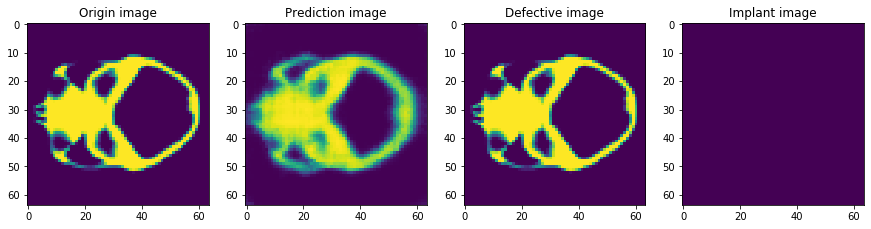

In [240]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 10))
#fig.suptitle('Horizontally stacked subplots')

ax1.set_title('Origin image')
ax1.imshow(image_downscaled[..., 1])

ax2.set_title('Prediction image')
ax2.imshow(prediction_[..., 1])

ax3.set_title('Defective image')
ax3.imshow(image_defective_[..., 1])

ax4.set_title('Implant image')
ax4.imshow(image_implant_[..., 1])

In [241]:
result_hd = hd(image_downscaled, prediction_ > 0.5)

In [242]:
result_hd

3.605551275463989

In [243]:
result_dc = dc(prediction_ > 0.5, image_downscaled)

In [244]:
result_dc

0.7778806840000904

In [245]:
result_bdc = bdc(image_downscaled, prediction_ > 0.5, image_implant_)

In [246]:
result_bdc

0.7486102027468934

In [250]:
result_bdc = bdc(prediction_ > 0.5, image_downscaled, image_downscaled - image_defective_)

In [251]:
result_bdc

0.7486102027468934

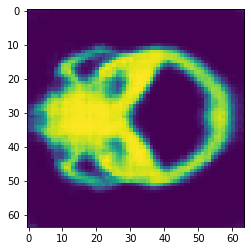

In [89]:
plt.imshow(prediction_[..., 1])

In [60]:
def bunarization(img):
    out = img.copy()
    for i in range(img.shape[-1]):
        out[..., i] = img[..., i] > 0.5
    return out

In [62]:
out_ex = bunarization(exmpl).astype(np.int32)

In [63]:
k3d.voxels(out_ex)

Output()

## End metrics evaluating

In [7]:
print(img.header.get_data_shape())
print(img.header.get_data_dtype())
print(f'{img.header.get_zooms()} in mm')

(512, 512, 331)
int32
(0.416016, 0.416016, 0.5) in mm


In [8]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 331   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.416016 0.416016 0.5      0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 106.5
qoffset_y       : 148.1
qoffset_z       : -438.6
s

In [52]:
data = img.get_fdata().astype(np.int32)

In [57]:
np.unique(data[..., 0])

array([0, 1], dtype=int32)

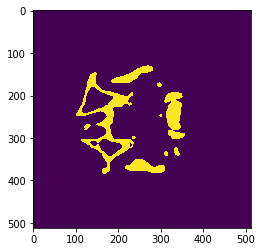

In [55]:
plt.imshow(data[..., 0])

In [10]:
k3d.voxels(data)

/Users/mariadonskova/opt/anaconda3/lib/python3.7/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int32" does not match required type "uint8". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [11]:
def voxel2pcd(grid, vox_size):
    if type(vox_size) is float:
        vox_size = [vox_size] * 3
    elif type(vox_size) in (list, tuple):
        pass
    else:
        raise ValueError(f'Wrong vox_size {vox_size}')
        
    assert len(grid.shape) == 3
    x, y, z = grid.shape
    dx, dy, dz = vox_size
    n_occupated = np.sum(grid)
    pcd = np.empty((n_occupated, 3), dtype=np.float32)
    cnt = 0
    for idx, occupated in np.ndenumerate(grid):
        if not occupated:
            continue
        i, j, k = idx
        pcd[cnt] = [i*dx, j*dy, k*dz]
        cnt += 1
    return pcd

In [12]:
pcd = voxel2pcd(data, img.header.get_zooms())

In [13]:
mean = pcd.mean(axis=0)
mean.shape

(3,)

In [14]:
k3d_mean = k3d.points(mean, color=0xff0000, point_size=3)
k3d_pcd = k3d.points(pcd, color=0xff, point_size=0.1)

In [15]:
plot = k3d.plot()
plot += k3d_mean
plot += k3d_pcd
k3d_mean.shader = '3d'
k3d_pcd.shader = '3d'
plot.display()

Output()

In [16]:
k3d_pcd

Output()

In [17]:
o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd))

In [18]:
o3d.io.write_point_cloud('examples/011_pcd.ply', o3d_pcd)

[Open3D WARNING] Write PLY failed: unable to open file: examples/011_pcd.ply


False

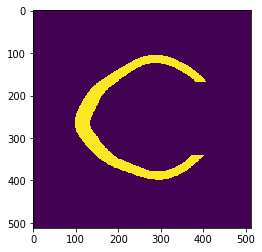

In [19]:
plt.imshow(data[:, :, 250])

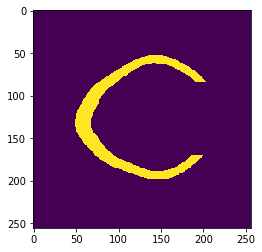

In [20]:
tmp = data[:, :, 250]
plt.imshow(zoom(tmp, (0.5, 0.5)))

In [21]:
%time zoom(tmp, (0.5, 0.5))

CPU times: user 21.7 ms, sys: 2.18 ms, total: 23.9 ms
Wall time: 22.2 ms


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [22]:
%time tr.rescale(tmp, (0.5, 0.5))

CPU times: user 15.1 ms, sys: 5.2 ms, total: 20.3 ms
Wall time: 19.8 ms


array([[2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10],
       [2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10],
       [2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10],
       ...,
       [2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10],
       [2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10],
       [2.32830644e-10, 2.32830644e-10, 2.32830644e-10, ...,
        2.32830644e-10, 2.32830644e-10, 2.32830644e-10]])

In [23]:
data.shape

(512, 512, 331)

In [24]:
%time np.take(data, 20, axis=1).shape

CPU times: user 1.37 s, sys: 212 ms, total: 1.58 s
Wall time: 1.64 s


(512, 331)

In [25]:
%time data[:, 20, :]

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.9 µs


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [26]:
%time slc = [slice(None)] * 3; slc[1] = slice(19, 20); data[slc].squeeze().shape

CPU times: user 1.06 ms, sys: 1.84 ms, total: 2.9 ms
Wall time: 2.95 ms


/Users/mariadonskova/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


(512, 331)